In [1]:
# Tested on python 3.6.4 
%matplotlib inline

import numpy as np # 1.13.3
from scipy.integrate import odeint # 1.0.0
import scipy.optimize as op
import scipy.stats as stats
import matplotlib.pyplot as plt # 2.1.1
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import MaxNLocator

import pandas as pd # 0.22.0
import emcee # 2.2.1
import corner # 2.0.1
import progressbar # 3.34.3
import seaborn as sns # 0.8.1
from cycler import cycler # 0.10.0

from helper import * # helper.py

print('emcee version', emcee.__version__)

# Directories defined here 
DIR_DATA = './data/'
DIR_PLOTS = './plots/'
DIR_OUT = './output/'

emcee version 2.2.1


This jupyter notebook fits Hill-function models to data from the 2018 Swank et al. paper using the [emcee](http://dfm.io/emcee/current/) package. The code in this notebook requires the following data files, which are located in `DIR_DATA`:

    2site_coop_PDZ.csv
    2site_coop_GCN.csv
    2site_coop_AAGCN.csv
    
The results are used to generate Supplementary Figure S6. Plots are written into `DIR_PLOTS` while MCMC samples are written into `DIR_OUT`. Warning: sample files may be very large.

# Dose response - Hill function models

Standard Hill function models predict an output given by:
\begin{equation}
y=y_0+\frac{y_1-y_0}{1+\left(\frac{R}{K}\right)^n}
\end{equation}
This model can be fit to each dose response curve; however it is not possible to consistently fit Hill functions to the entire datset as in this model the parameters between datasets are independent. Thus it is a purely phenomenological description of the data.

In [2]:
def Hill(y0,y1,x,K,n):
    return(y0+(y1-y0)/(1+(x/K)**n))

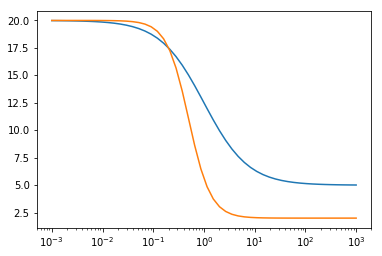

In [3]:
# Show example

R = np.logspace(-3,3,50)
y1 = 20
plt.semilogx(R,Hill(y0=5,y1=y1,x=R,K=1,n=1)) ; 
plt.semilogx(R,Hill(y0=2,y1=y1,x=R,K=0.5,n=2)) ; plt.show()

## PDZ fits

In [4]:
# Define MCMC functions for PDZ fit

def normalprior(param,mu,sigma):
    return np.log( 1.0 / (np.sqrt(2*np.pi)*sigma) ) - 0.5*(param - mu)**2/sigma**2

def lnlike(theta,x,y,yerr):

    y_0,y_1,K,n = theta
    
    ypred1 = Hill(y_0,y_1,x,K,n)    
    inv_sigma2_1 = 1/(yerr**2)

    X1 = np.sum((ypred1-y)**2*inv_sigma2_1-np.log(np.pi*2*inv_sigma2_1))

    return -0.5*(X1)

def lnprob(theta,x,y,yerr):
    lp = lnprior(theta,y,yerr)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta,x,y,yerr)

def MCMC(x,y,yerr,ZFname,parameternames,nwalkers,ndim,
         iterations,pos,tburn,threads,DIR_OUT,DIR_PLOTS):
    # Initialise MCMC
    sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,a=2,args=(x,y,yerr),threads=threads)

    bar = progressbar.ProgressBar(max_value=iterations)
    # Run MCMC
    for i, result in enumerate(sampler.sample(pos, iterations=iterations)):
        bar.update(i)

    samples = sampler.chain[:,:,:].reshape((-1,ndim)) # shape = (nsteps*nwalkers, ndim)
    samplesnoburn = sampler.chain[:,tburn:,:].reshape((-1,ndim)) 

    df = pd.DataFrame(samples)
    df.to_csv(path_or_buf=DIR_OUT+'samplesout_'+ZFname+'.csv',sep=',') #Uncomment to save

    plottraces2(samples,parameternames,nwalkers,iterations,ZFname,DIR_PLOTS)
    fig = corner.corner(samplesnoburn, labels=parameternames,
                        quantiles=[0.16, 0.5, 0.84],show_titles=True, 
                        title_fmt='.2e', title_kwargs={"fontsize": 12},verbose=True)
    fig.savefig(DIR_PLOTS+ZFname+'triangle.png')
    return(samplesnoburn)



### ADD

 99% (9998 of 10000) |################### | Elapsed Time: 0:04:36 ETA:  0:00:00

Quantiles:
[(0.16, 1808.3790156183154), (0.5, 2063.3981619119054), (0.84, 2304.5130576216629)]
Quantiles:
[(0.16, 3516.9724203413889), (0.5, 3773.6181267181751), (0.84, 4056.4793414633446)]
Quantiles:
[(0.16, 0.044552929880884412), (0.5, 0.095711441514997525), (0.84, 0.1984523563853853)]
Quantiles:
[(0.16, 0.60230353014160665), (0.5, 1.044188832259382), (0.84, 1.6892815421425564)]


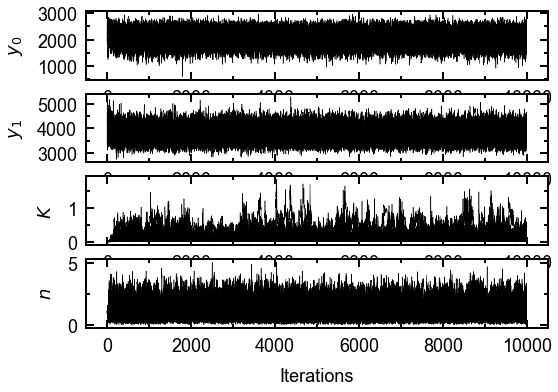

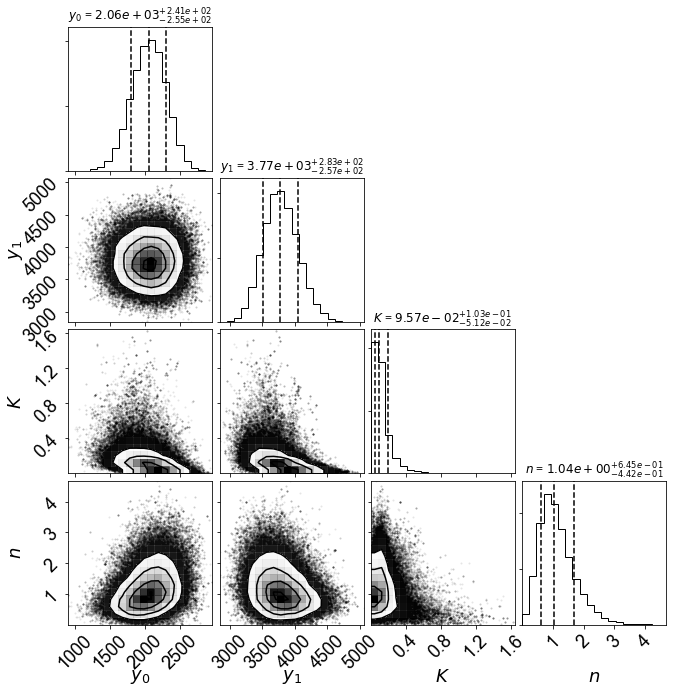

In [5]:
def lnprior(theta,y,yerr):
    y_0,y_1,K,n = theta
    if not (0<y_0 and 0<y_1 and 0<K and 0<n): 
        return -np.inf # Hard-cutoff for positive value constraint

    log_Pr1 = normalprior(y_0,y[0],yerr[0]) # Normal prior for y0
    log_Pr2 = normalprior(y_1,y[-1],yerr[-1]) # Normal prior for y1
    log_Pr3 = normalprior(K,5e-2,5e-1) # Wide normal prior for K
    log_Pr4 = normalprior(n,1,1) # Wide normal prior for n
    
    return log_Pr1 + log_Pr2 + log_Pr3 + log_Pr4

# Read PDZ data
df = pd.read_csv(DIR_DATA+'2site_coop_PDZ.csv',delimiter=',')
ydatnames = ['BCB+ADD cooperative', 'BCB+ADD non-cooperative', 'BCB-PDZ', 'ADD-L']
yerrnames = ['BCB+ADD cooperative std', 'BCB+ADD non-cooperative std', 'BCB-PDZ std', 'ADD-L std']
titration = df['ZF ratio']

xd = titration
xs = titration/2

y1 = df[ydatnames[0]].values # Cooperative
yerr1 = df[yerrnames[0]].values

y2 = df[ydatnames[1]].values # Non-cooperative
yerr2 = df[yerrnames[1]].values

y3 = df[ydatnames[2]].values # BCB-PDZ
yerr3 = df[yerrnames[2]].values

y4 = df[ydatnames[3]].values # ADD-L
yerr4 = df[yerrnames[3]].values

# Set up MCMC
np.random.seed(0) # For reproducible outputs   
parameternames = ["$y_0$","$y_1$","$K$","$n$"]
nwalkers,ndim,iterations,tburn,threads = 50,4,10000,5000,2 # Set threads correctly for parallelisation
pos = [np.array([
    y4[0]*(1+1/10*np.random.randn()), # smallest
    y4[-1]*(1+1/10*np.random.randn()), # largest
    1e-2*(1+1/10*np.random.randn()),
    1*(1+1/10*np.random.randn())
]) for i in range(nwalkers)] # Initialise walkers 

# Run MCMC
samples_noburn = MCMC(xs,y4,yerr4,'PDZ_Hill_ADD',parameternames,nwalkers,ndim,
                      iterations,pos,tburn,threads,DIR_OUT,DIR_PLOTS)

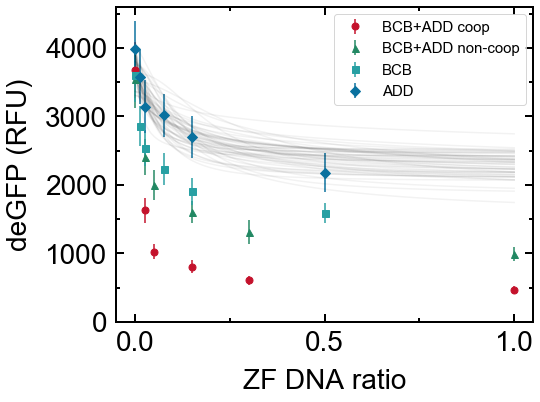

In [6]:
numberofmodeltraces=50
plottracesHill(y1,yerr1,y2,yerr2,y3,yerr3,y4,yerr4,titration,'PDZ_Hill_ensemble_ADD',
               Hill,DIR_PLOTS,
               numberofmodeltraces=50,samples=samples_noburn,quant=None)

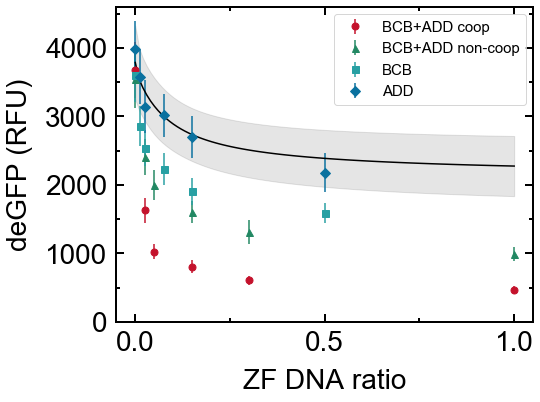

In [7]:
# Construct intervals and plot max likelihood and shaded intervals
np.random.seed(0) # For reproducible outputs   
modelscale = np.linspace(0,1,100)
numberofmodeltraces = 1000

ypred1 = np.zeros((len(modelscale),numberofmodeltraces))

i=0
for y_0,y_1,K,n in samples_noburn[np.random.randint(len(samples_noburn), size=numberofmodeltraces)]:
    ypred1[:,i]=Hill(y_0,y_1,modelscale,K,n)     
    i+=1
    
# 2-sigma distributions
quant1 = [np.mean(ypred1,axis=1)-2*np.std(ypred1,axis=1),
        np.mean(ypred1,axis=1),
        np.mean(ypred1,axis=1)+2*np.std(ypred1,axis=1)]

quant = [quant1]

plottracesHill(y1,yerr1,y2,yerr2,y3,yerr3,y4,yerr4,titration,'PDZ_Hill_maxlike_ADD',
               Hill,DIR_PLOTS,
               numberofmodeltraces=50,samples=samples_noburn,quant=quant)

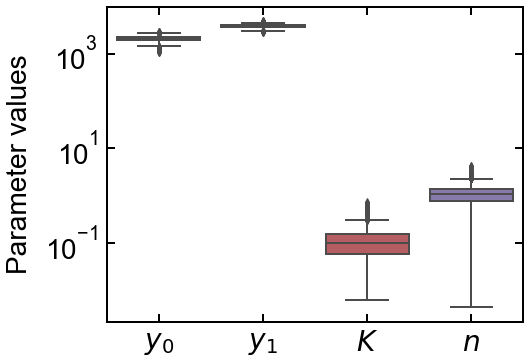

In [8]:
parameternames = ["$y_0$","$y_1$","$K$","$n$"]
nwalkers = 50
iterations = 10000
tburn = 9900
ZFname='PDZ_Hill_ADD'
boxplots(ZFname,parameternames,nwalkers,iterations,tburn,DIR_PLOTS,DIR_OUT)

### BCB-PDZ

 99% (9999 of 10000) |################### | Elapsed Time: 0:05:09 ETA:  0:00:00

Quantiles:
[(0.16, 1411.680508190168), (0.5, 1542.338120167434), (0.84, 1667.0879189817783)]
Quantiles:
[(0.16, 3142.6771986504627), (0.5, 3434.3074799574706), (0.84, 3730.2946281262221)]
Quantiles:
[(0.16, 0.020489462569493903), (0.5, 0.03513051242767689), (0.84, 0.061666465230499193)]
Quantiles:
[(0.16, 0.75291874732304287), (0.5, 1.0553142661620944), (0.84, 1.4984223802303895)]


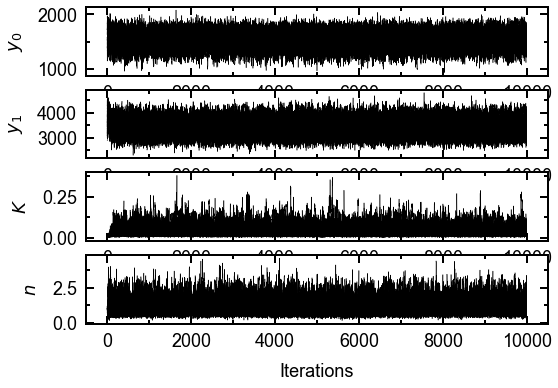

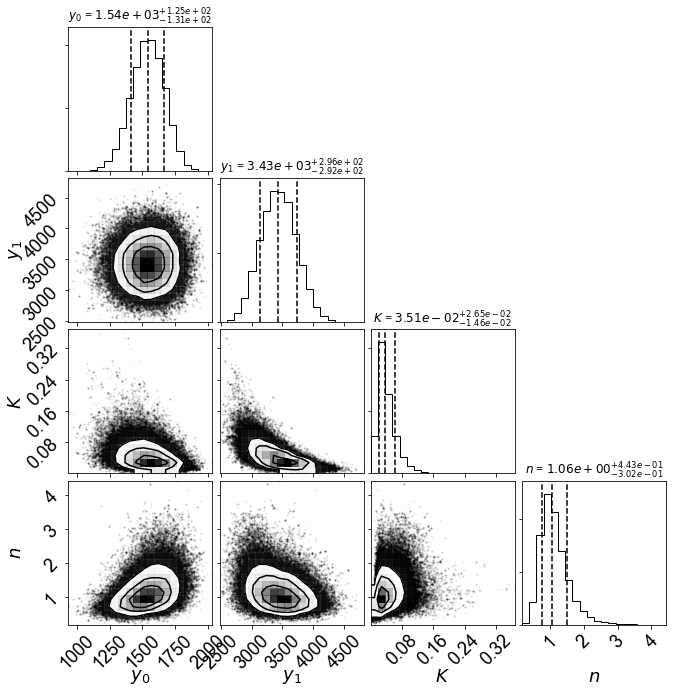

In [9]:
def lnprior(theta,y,yerr):
    y_0,y_1,K,n = theta
    if not (0<y_0 and 0<y_1 and 0<K and 0<n): 
        return -np.inf # Hard-cutoff for positive value constraint

    log_Pr1 = normalprior(y_0,y[0],yerr[0]) # Normal prior for y0
    log_Pr2 = normalprior(y_1,y[-1],yerr[-1]) # Normal prior for y1
    log_Pr3 = normalprior(K,5e-2,5e-1) # Wide normal prior for K
    log_Pr4 = normalprior(n,1,1) # Wide normal prior for n
    
    return log_Pr1 + log_Pr2 + log_Pr3 + log_Pr4


# Read PDZ data
df = pd.read_csv(DIR_DATA+'2site_coop_PDZ.csv',delimiter=',')
ydatnames = ['BCB+ADD cooperative', 'BCB+ADD non-cooperative', 'BCB-PDZ', 'ADD-L']
yerrnames = ['BCB+ADD cooperative std', 'BCB+ADD non-cooperative std', 'BCB-PDZ std', 'ADD-L std']
titration = df['ZF ratio']

xd = titration
xs = titration/2

y1 = df[ydatnames[0]].values # Cooperative
yerr1 = df[yerrnames[0]].values

y2 = df[ydatnames[1]].values # Non-cooperative
yerr2 = df[yerrnames[1]].values

y3 = df[ydatnames[2]].values # BCB-PDZ
yerr3 = df[yerrnames[2]].values

y4 = df[ydatnames[3]].values # ADD-L
yerr4 = df[yerrnames[3]].values

# Set up MCMC
np.random.seed(0) # For reproducible outputs   
parameternames = ["$y_0$","$y_1$","$K$","$n$"]
nwalkers,ndim,iterations,tburn,threads = 50,4,10000,5000,2 # Set threads correctly for parallelisation
pos = [np.array([
    y3[0]*(1+1/10*np.random.randn()), # smallest
    y3[-1]*(1+1/10*np.random.randn()), # largest
    1e-2*(1+1/10*np.random.randn()),
    1*(1+1/10*np.random.randn())
]) for i in range(nwalkers)] # Initialise walkers 

# Run MCMC
samples_noburn = MCMC(xs,y3,yerr3,'PDZ_Hill_BCB',parameternames,nwalkers,ndim,
                      iterations,pos,tburn,threads,DIR_OUT,DIR_PLOTS)

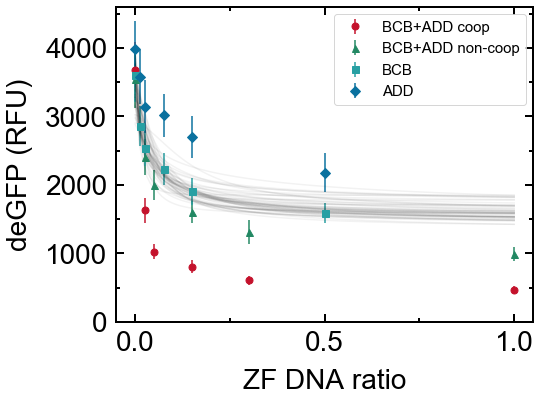

In [10]:
numberofmodeltraces=50
plottracesHill(y1,yerr1,y2,yerr2,y3,yerr3,y4,yerr4,titration,'PDZ_Hill_ensemble_BCB',
               Hill,DIR_PLOTS,
               numberofmodeltraces=50,samples=samples_noburn,quant=None)

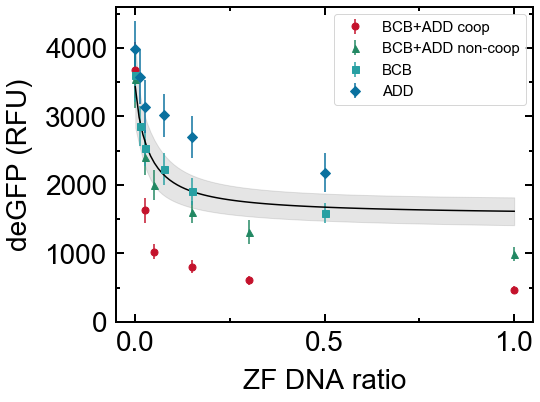

In [11]:
# Construct intervals and plot max likelihood and shaded intervals
np.random.seed(0) # For reproducible outputs   
modelscale = np.linspace(0,1,100)
numberofmodeltraces = 1000

ypred1 = np.zeros((len(modelscale),numberofmodeltraces))

i=0
for y_0,y_1,K,n in samples_noburn[np.random.randint(len(samples_noburn), size=numberofmodeltraces)]:
    ypred1[:,i]=Hill(y_0,y_1,modelscale,K,n)     
    i+=1
    
# 2-sigma distributions
quant1 = [np.mean(ypred1,axis=1)-2*np.std(ypred1,axis=1),
          np.mean(ypred1,axis=1),
          np.mean(ypred1,axis=1)+2*np.std(ypred1,axis=1)]

quant = [quant1]

plottracesHill(y1,yerr1,y2,yerr2,y3,yerr3,y4,yerr4,titration,'PDZ_Hill_maxlike_BCB',
               Hill,DIR_PLOTS,
               numberofmodeltraces=50,samples=samples_noburn,quant=quant)

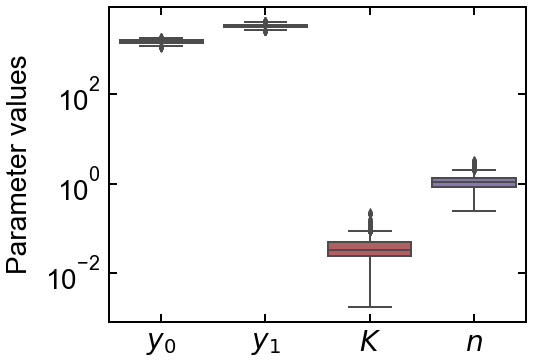

In [12]:
parameternames=["$y_0$","$y_1$","$K$","$n$"]
nwalkers=50
iterations=10000
tburn=9900
ZFname='PDZ_Hill_BCB'
boxplots(ZFname,parameternames,nwalkers,iterations,tburn,DIR_PLOTS,DIR_OUT)

### BCB+ADD non coop

 99% (9996 of 10000) |################### | Elapsed Time: 0:05:21 ETA:  0:00:00

Quantiles:
[(0.16, 862.94272472104979), (0.5, 950.05335452114059), (0.84, 1036.6419706824779)]
Quantiles:
[(0.16, 3103.1880234527989), (0.5, 3403.8431747858549), (0.84, 3700.3419333968004)]
Quantiles:
[(0.16, 0.028824806948916586), (0.5, 0.042445551227745404), (0.84, 0.062600045672360494)]
Quantiles:
[(0.16, 0.7760837588329772), (0.5, 0.98734836472708898), (0.84, 1.2699796500740823)]


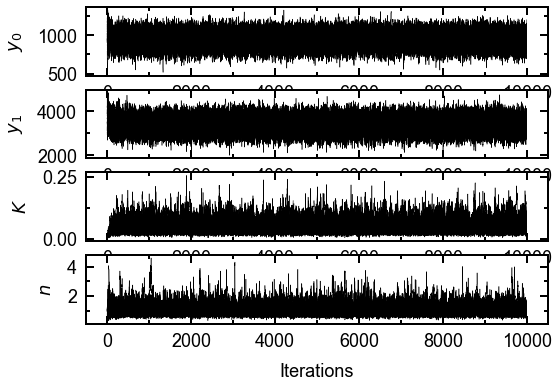

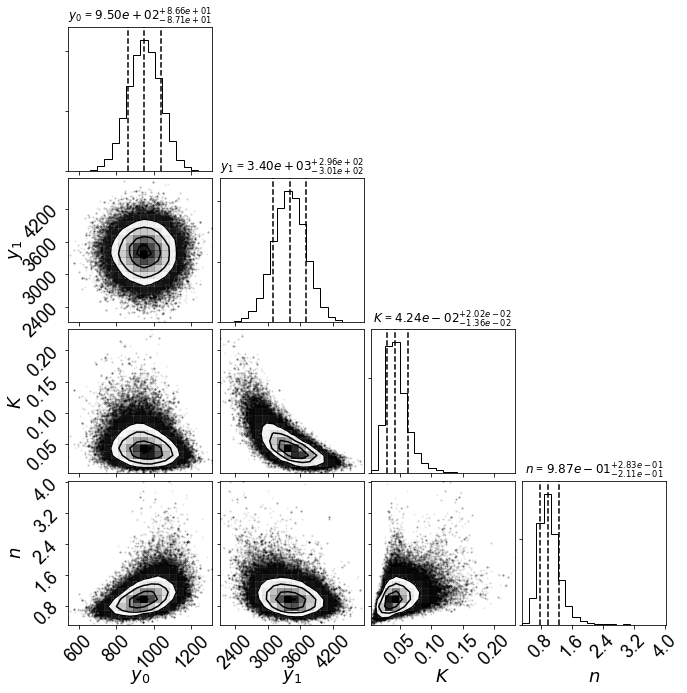

In [13]:
def lnprior(theta,y,yerr):
    y_0,y_1,K,n = theta
    if not (0<y_0 and 0<y_1 and 0<K and 0<n): 
        return -np.inf # Hard-cutoff for positive value constraint

    log_Pr1 = normalprior(y_0,y[0],yerr[0]) # Normal prior for y0
    log_Pr2 = normalprior(y_1,y[-1],yerr[-1]) # Normal prior for y1
    log_Pr3 = normalprior(K,5e-2,5e-1) # Wide normal prior for K
    log_Pr4 = normalprior(n,1,2) # Wide normal prior for n
    
    return log_Pr1 + log_Pr2 + log_Pr3 + log_Pr4

# Read PDZ data
df = pd.read_csv(DIR_DATA+'2site_coop_PDZ.csv',delimiter=',')
ydatnames = ['BCB+ADD cooperative', 'BCB+ADD non-cooperative', 'BCB-PDZ', 'ADD-L']
yerrnames = ['BCB+ADD cooperative std', 'BCB+ADD non-cooperative std', 'BCB-PDZ std', 'ADD-L std']
titration = df['ZF ratio']

xd = titration
xs = titration/2

y1 = df[ydatnames[0]].values # Cooperative
yerr1 = df[yerrnames[0]].values

y2 = df[ydatnames[1]].values # Non-cooperative
yerr2 = df[yerrnames[1]].values

y3 = df[ydatnames[2]].values # BCB-PDZ
yerr3 = df[yerrnames[2]].values

y4 = df[ydatnames[3]].values # ADD-L
yerr4 = df[yerrnames[3]].values

# Set up MCMC
np.random.seed(0) # For reproducible outputs   
parameternames=["$y_0$","$y_1$","$K$","$n$"]
nwalkers,ndim,iterations,tburn,threads=50,4,10000,5000,2 # Set threads correctly for parallelisation
pos=[np.array([
    y2[0]*(1+1/10*np.random.randn()), # smallest
    y2[-1]*(1+1/10*np.random.randn()), # largest
    1e-2*(1+1/10*np.random.randn()),
    1*(1+1/10*np.random.randn())
]) for i in range(nwalkers)] # Initialise walkers 

# Run MCMC
samples_noburn = MCMC(xd,y2,yerr2,'PDZ_Hill_nc',parameternames,nwalkers,ndim,
                      iterations,pos,tburn,threads,DIR_OUT,DIR_PLOTS)

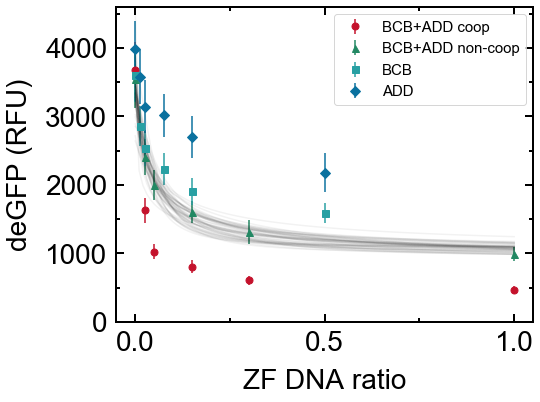

In [14]:
numberofmodeltraces=50
plottracesHill(y1,yerr1,y2,yerr2,y3,yerr3,y4,yerr4,titration,'PDZ_Hill_ensemble_nc',
               Hill,DIR_PLOTS,
               numberofmodeltraces=50,samples=samples_noburn,quant=None)

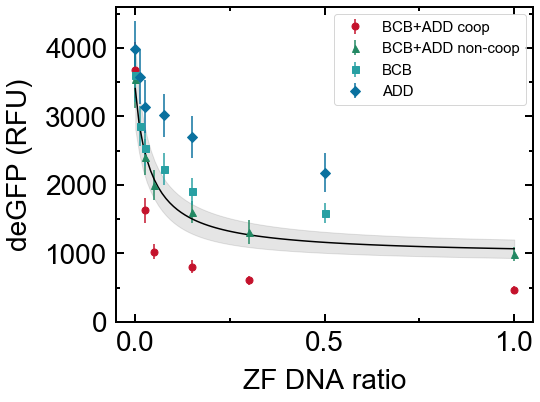

In [15]:
# Construct intervals and plot max likelihood and shaded intervals
np.random.seed(0) # For reproducible outputs   
modelscale = np.linspace(0,1,100)
numberofmodeltraces = 1000

ypred1 = np.zeros((len(modelscale),numberofmodeltraces))

i=0
for y_0,y_1,K,n in samples_noburn[np.random.randint(len(samples_noburn), size=numberofmodeltraces)]:
    ypred1[:,i] = Hill(y_0,y_1,modelscale,K,n)     
    i+=1
    
# 2-sigma distributions
quant1 = [np.mean(ypred1,axis=1)-2*np.std(ypred1,axis=1),np.mean(ypred1,axis=1),np.mean(ypred1,axis=1)+2*np.std(ypred1,axis=1)]

quant = [quant1]

plottracesHill(y1,yerr1,y2,yerr2,y3,yerr3,y4,yerr4,titration,'PDZ_Hill_maxlike_nc',
               Hill,DIR_PLOTS,
               numberofmodeltraces=50,samples=samples_noburn,quant=quant)

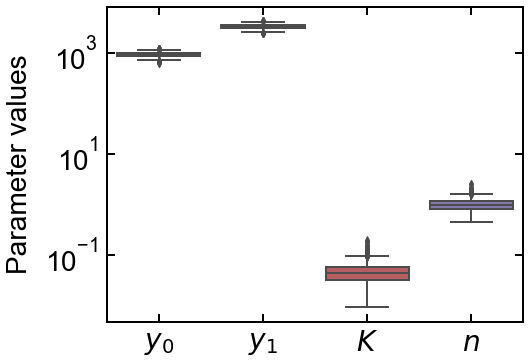

In [16]:
parameternames=["$y_0$","$y_1$","$K$","$n$"]
nwalkers=50
iterations=10000
tburn=9900
ZFname='PDZ_Hill_nc'
boxplots(ZFname,parameternames,nwalkers,iterations,tburn,DIR_PLOTS,DIR_OUT)

### BCB+ADD coop

 99% (9997 of 10000) |################### | Elapsed Time: 0:05:13 ETA:  0:00:00

Quantiles:
[(0.16, 390.14777192781798), (0.5, 439.34585207402125), (0.84, 486.3669889479325)]
Quantiles:
[(0.16, 2339.9046539472661), (0.5, 2505.7596602346312), (0.84, 2674.0326645048726)]
Quantiles:
[(0.16, 0.038505556097640781), (0.5, 0.040519249386776993), (0.84, 0.042561055781348299)]
Quantiles:
[(0.16, 1.0748560269403011), (0.5, 1.2808018573606628), (0.84, 1.5740691823351445)]


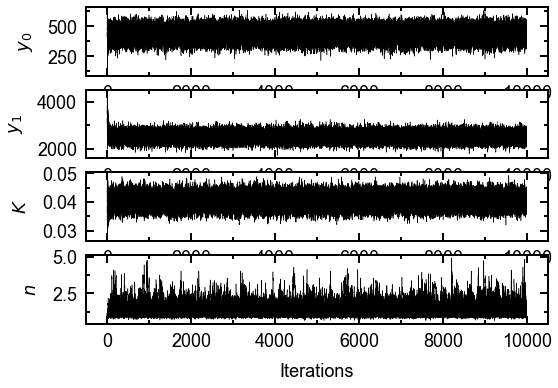

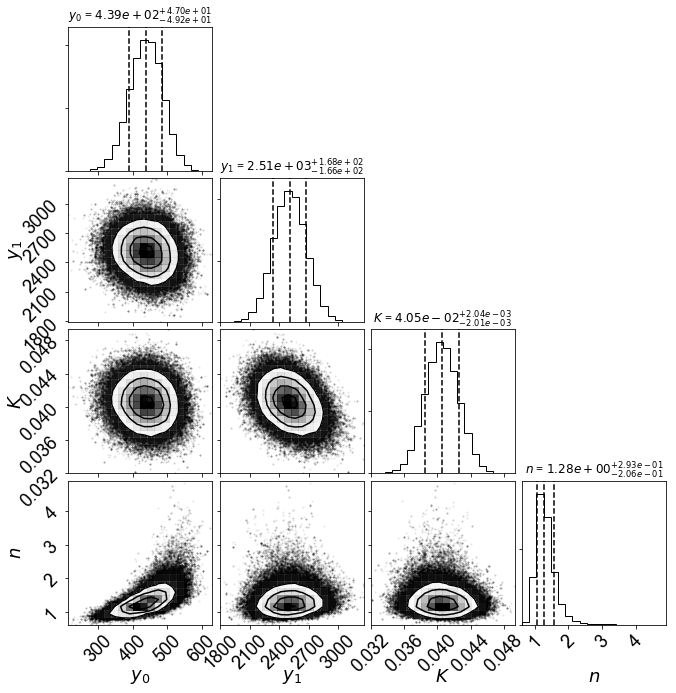

In [17]:
# Change priors

def lnprior(theta,y,yerr):
    y_0,y_1,K,n=theta
    if not (0<y_0 and 0<y_1 and 0<K and 0<n): 
        return -np.inf # Hard-cutoff for positive value constraint

    log_Pr1 = normalprior(y_0,y[0],yerr[0]) # Normal prior for y0
    log_Pr2 = normalprior(y_1,y[-1],yerr[-1]) # Normal prior for y1
    log_Pr3 = normalprior(K,0.042435195060968933,2e-3) # Strong prior for K, essentially fixed by non-coop experiment
    log_Pr4 = normalprior(n,1,2) # Wide normal prior for n
    
    return log_Pr1+ log_Pr2+ log_Pr3+ log_Pr4

# Read PDZ data
df = pd.read_csv(DIR_DATA+'2site_coop_PDZ.csv',delimiter=',')
ydatnames = ['BCB+ADD cooperative', 'BCB+ADD non-cooperative', 'BCB-PDZ', 'ADD-L']
yerrnames = ['BCB+ADD cooperative std', 'BCB+ADD non-cooperative std', 'BCB-PDZ std', 'ADD-L std']
titration = df['ZF ratio']

xd = titration
xs = titration/2

y1 = df[ydatnames[0]].values # Cooperative
yerr1 = df[yerrnames[0]].values

y2 = df[ydatnames[1]].values # Non-cooperative
yerr2 = df[yerrnames[1]].values

y3 = df[ydatnames[2]].values # BCB-PDZ
yerr3 = df[yerrnames[2]].values

y4 = df[ydatnames[3]].values # ADD-L
yerr4 = df[yerrnames[3]].values

# Set up MCMC
np.random.seed(0) # For reproducible outputs   
parameternames = ["$y_0$","$y_1$","$K$","$n$"]
nwalkers,ndim,iterations,tburn,threads = 50,4,10000,5000,2 # Set threads correctly for parallelisation
pos = [np.array([
    y1[0]*(1+1/10*np.random.randn()), # smallest
    y1[-1]*(1+1/10*np.random.randn()), # largest
    4e-2*(1+1/10*np.random.randn()),
    1*(1+1/10*np.random.randn())
]) for i in range(nwalkers)] # Initialise walkers 

# Run MCMC
samples_noburn = MCMC(xd,y1,yerr1,'PDZ_Hill_c',parameternames,nwalkers,ndim,
                      iterations,pos,tburn,threads,DIR_OUT,DIR_PLOTS)

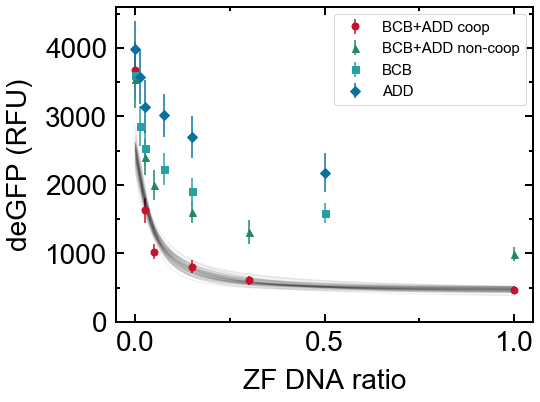

In [18]:
numberofmodeltraces=50
plottracesHill(y1,yerr1,y2,yerr2,y3,yerr3,y4,yerr4,titration,'PDZ_Hill_ensemble_c',
               Hill,DIR_PLOTS,
               numberofmodeltraces=50,samples=samples_noburn,quant=None)

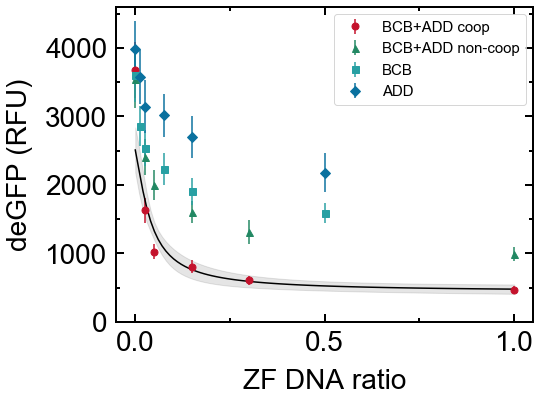

In [19]:
# Construct intervals and plot max likelihood and shaded intervals
np.random.seed(0) # For reproducible outputs   
modelscale = np.linspace(0,1,100)
numberofmodeltraces = 1000

ypred1 = np.zeros((len(modelscale),numberofmodeltraces))

i=0
for y_0,y_1,K,n in samples_noburn[np.random.randint(len(samples_noburn), size=numberofmodeltraces)]:
    ypred1[:,i] = Hill(y_0,y_1,modelscale,K,n)     
    i+=1
    
# 2-sigma distributions
quant1 = [np.mean(ypred1,axis=1)-2*np.std(ypred1,axis=1),
          np.mean(ypred1,axis=1),
          np.mean(ypred1,axis=1)+2*np.std(ypred1,axis=1)]

quant = [quant1]

plottracesHill(y1,yerr1,y2,yerr2,y3,yerr3,y4,yerr4,titration,'PDZ_Hill_maxlike_c',
               Hill,DIR_PLOTS,
               numberofmodeltraces=50,samples=samples_noburn,quant=quant)

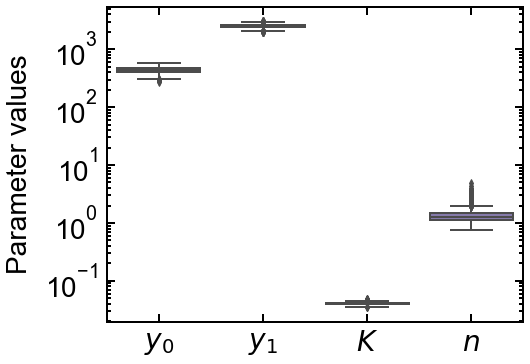

In [20]:
parameternames=["$y_0$","$y_1$","$K$","$n$"]
nwalkers=50
iterations=10000
tburn=9900
ZFname='PDZ_Hill_c'
boxplots(ZFname,parameternames,nwalkers,iterations,tburn,DIR_PLOTS,DIR_OUT)

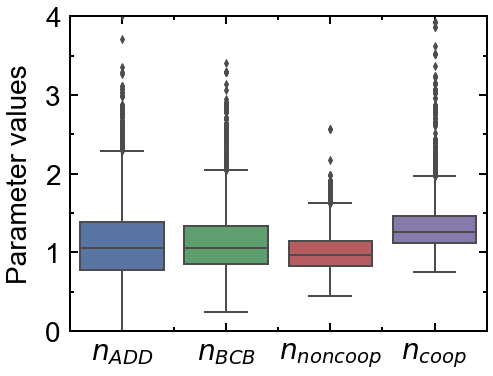

In [21]:
boxplots2(nwalkers,iterations,tburn,'PDZ',DIR_PLOTS,DIR_OUT)

## GCN fits

In [22]:
# Define MCMC functions for GCN fit

def normalprior(param,mu,sigma):
    return np.log( 1.0 / (np.sqrt(2*np.pi)*sigma) ) - 0.5*(param - mu)**2/sigma**2

def lnlike(theta,x,y,yerr):

    y_0,y_1,K,n = theta
    
    ypred1 = Hill(y_0,y_1,x,K,n)    
    inv_sigma2_1 = 1/(yerr**2)

    X1 = np.sum((ypred1-y)**2*inv_sigma2_1-np.log(np.pi*2*inv_sigma2_1))

    return -0.5*(X1)

def lnprob(theta,x,y,yerr):
    lp = lnprior(theta,y,yerr)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta,x,y,yerr)

def MCMC(x,y,yerr,ZFname,parameternames,nwalkers,ndim,
         iterations,pos,tburn,threads,DIR_OUT,DIR_PLOTS):
    # Initialise MCMC
    sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,a=2,args=(x,y,yerr),threads=threads)

    bar = progressbar.ProgressBar(max_value=iterations)
    # Run MCMC
    for i, result in enumerate(sampler.sample(pos, iterations=iterations)):
        bar.update(i)

    samples = sampler.chain[:,:,:].reshape((-1,ndim)) # shape = (nsteps*nwalkers, ndim)
    samplesnoburn = sampler.chain[:,tburn:,:].reshape((-1,ndim)) 

    df = pd.DataFrame(samples)
    df.to_csv(path_or_buf=DIR_OUT+'samplesout_'+ZFname+'.csv',sep=',') #Uncomment to save

    plottraces2(samples,parameternames,nwalkers,iterations,ZFname,DIR_PLOTS)
    fig = corner.corner(samplesnoburn, labels=parameternames,
                        quantiles=[0.16, 0.5, 0.84],show_titles=True, 
                        title_fmt='.2e', title_kwargs={"fontsize": 12},verbose=True)
    fig.savefig(DIR_PLOTS+ZFname+'triangle.png')
    return(samplesnoburn)



### ADD-GCN

 99% (9999 of 10000) |################### | Elapsed Time: 0:05:15 ETA:  0:00:00

Quantiles:
[(0.16, 1563.166637530986), (0.5, 1676.1150875934463), (0.84, 1784.7775308893895)]
Quantiles:
[(0.16, 3208.5752059103515), (0.5, 3479.0707385888954), (0.84, 3805.8539407080125)]
Quantiles:
[(0.16, 0.050368341895972106), (0.5, 0.078111470873421518), (0.84, 0.10785588302323576)]
Quantiles:
[(0.16, 0.92766081942527123), (0.5, 1.2816335479013805), (0.84, 1.8227596560848611)]


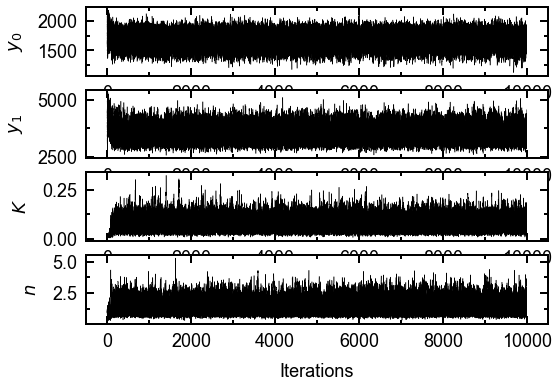

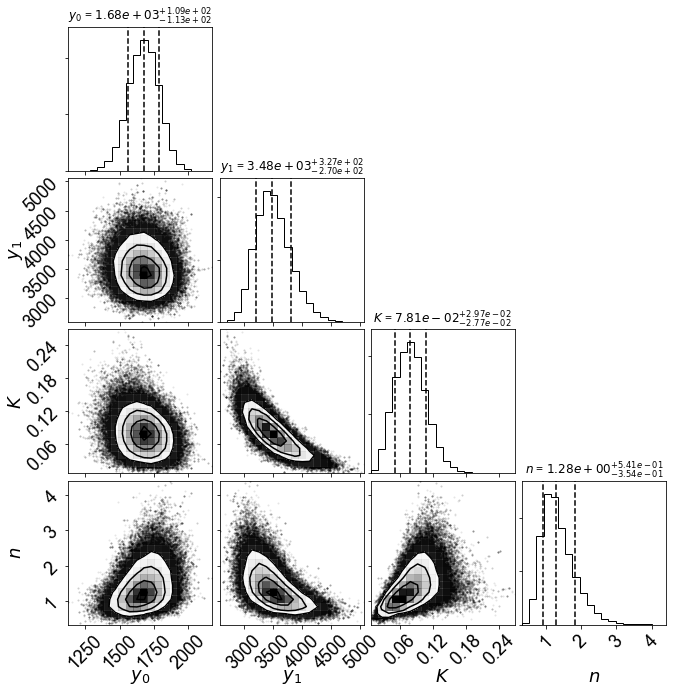

In [23]:
def lnprior(theta,y,yerr):
    y_0,y_1,K,n=theta
    if not (0<y_0 and 0<y_1 and 0<K and 0<n): 
        return -np.inf # Hard-cutoff for positive value constraint

    log_Pr1 = normalprior(y_0,y[0],yerr[0]) # Normal prior for y0
    log_Pr2 = normalprior(y_1,y[-1],yerr[-1]) # Normal prior for y1
    log_Pr3 = normalprior(K,5e-2,5e-1) # Wide normal prior for K
    log_Pr4 = normalprior(n,1,1) # Wide normal prior for n

    return log_Pr1 + log_Pr2 + log_Pr3 + log_Pr4

# Read GCN data
df = pd.read_csv(DIR_DATA+'2site_coop_GCN.csv',delimiter=',')
ydatnames = ['BCB+ADD cooperative', 'BCB+ADD non-cooperative', 'BCB-GCN', 'ADD-GCN']
yerrnames = ['BCB+ADD cooperative std', 'BCB+ADD non-cooperative std', 'BCB-GCN std', 'ADD-GCN std']
titration = df['ZF ratio']

xd = titration
xs = titration/2

y1 = df[ydatnames[0]].values # Cooperative
yerr1 = df[yerrnames[0]].values

y2 = df[ydatnames[1]].values # Non-cooperative
yerr2 = df[yerrnames[1]].values

y3 = df[ydatnames[2]].values # BCB-PDZ
yerr3 = df[yerrnames[2]].values

y4 = df[ydatnames[3]].values # ADD-L
yerr4 = df[yerrnames[3]].values

# Set up MCMC
np.random.seed(0) # For reproducible outputs   
parameternames = ["$y_0$","$y_1$","$K$","$n$"]
nwalkers,ndim,iterations,tburn,threads = 50,4,10000,5000,2 # Set threads correctly for parallelisation
pos = [np.array([
    y4[0]*(1+1/10*np.random.randn()), # smallest
    y4[-1]*(1+1/10*np.random.randn()), # largest
    1e-2*(1+1/10*np.random.randn()),
    1*(1+1/10*np.random.randn())
]) for i in range(nwalkers)] # Initialise walkers 

# Run MCMC
samples_noburn = MCMC(xs,y4,yerr4,'GCN_Hill_ADD',parameternames,nwalkers,ndim,
                      iterations,pos,tburn,threads,DIR_OUT,DIR_PLOTS)

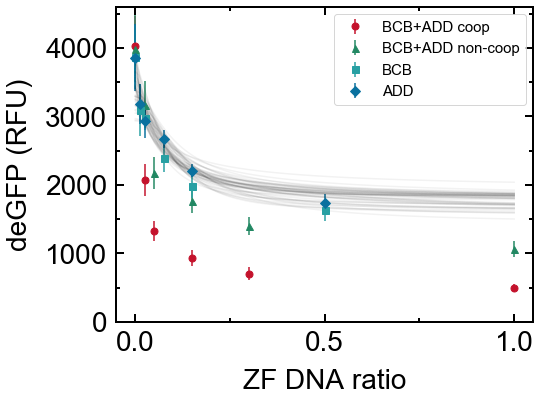

In [24]:
numberofmodeltraces = 50
plottracesHill(y1,yerr1,y2,yerr2,y3,yerr3,y4,yerr4,titration,'GCN_Hill_ensemble_ADD',
               Hill,DIR_PLOTS,
               numberofmodeltraces=50,samples=samples_noburn,quant=None)

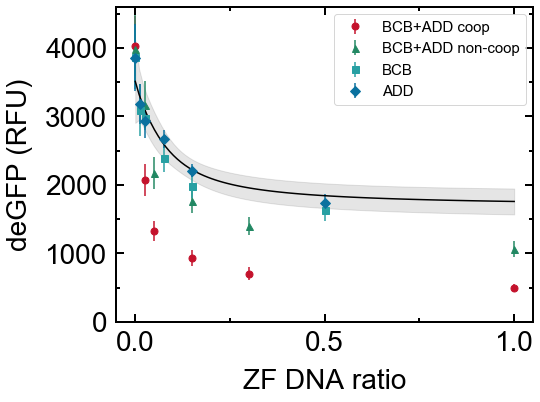

In [25]:
# Construct intervals and plot max likelihood and shaded intervals
np.random.seed(0) # For reproducible outputs   
modelscale = np.linspace(0,1,100)
numberofmodeltraces = 1000

ypred1 = np.zeros((len(modelscale),numberofmodeltraces))

i=0
for y_0,y_1,K,n in samples_noburn[np.random.randint(len(samples_noburn), size=numberofmodeltraces)]:
    ypred1[:,i] = Hill(y_0,y_1,modelscale,K,n)     
    i+=1
    
# 2-sigma distributions
quant1 = [np.mean(ypred1,axis=1)-2*np.std(ypred1,axis=1),
          np.mean(ypred1,axis=1),
          np.mean(ypred1,axis=1)+2*np.std(ypred1,axis=1)]

quant = [quant1]

plottracesHill(y1,yerr1,y2,yerr2,y3,yerr3,y4,yerr4,titration,'GCN_Hill_maxlike_ADD',
               Hill,DIR_PLOTS,
               numberofmodeltraces=50,samples=samples_noburn,quant=quant)

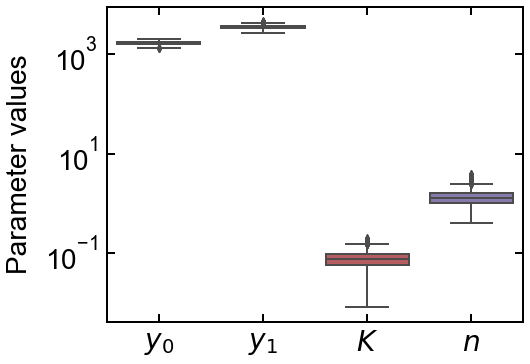

In [26]:
parameternames = ["$y_0$","$y_1$","$K$","$n$"]
nwalkers = 50
iterations = 10000
tburn = 9900
ZFname = 'GCN_Hill_ADD'
boxplots(ZFname,parameternames,nwalkers,iterations,tburn,DIR_PLOTS,DIR_OUT)

### BCB-GCN

 99% (9999 of 10000) |################### | Elapsed Time: 0:06:41 ETA:  0:00:00

Quantiles:
[(0.16, 1440.790594451194), (0.5, 1575.1242085984702), (0.84, 1703.9856002238721)]
Quantiles:
[(0.16, 3338.7945773802448), (0.5, 3642.5854317184599), (0.84, 3975.214860811463)]
Quantiles:
[(0.16, 0.031784172638615216), (0.5, 0.048404594428673266), (0.84, 0.073073638231535537)]
Quantiles:
[(0.16, 0.90307742355170562), (0.5, 1.2148861439338865), (0.84, 1.6727665055204544)]


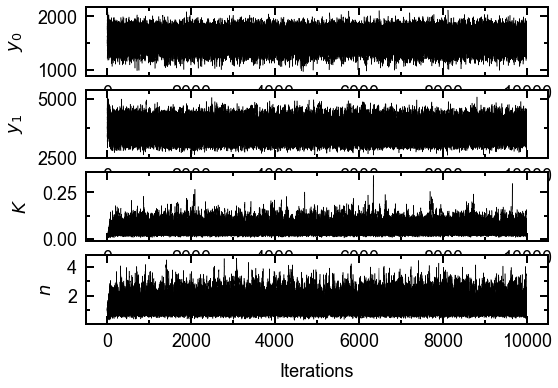

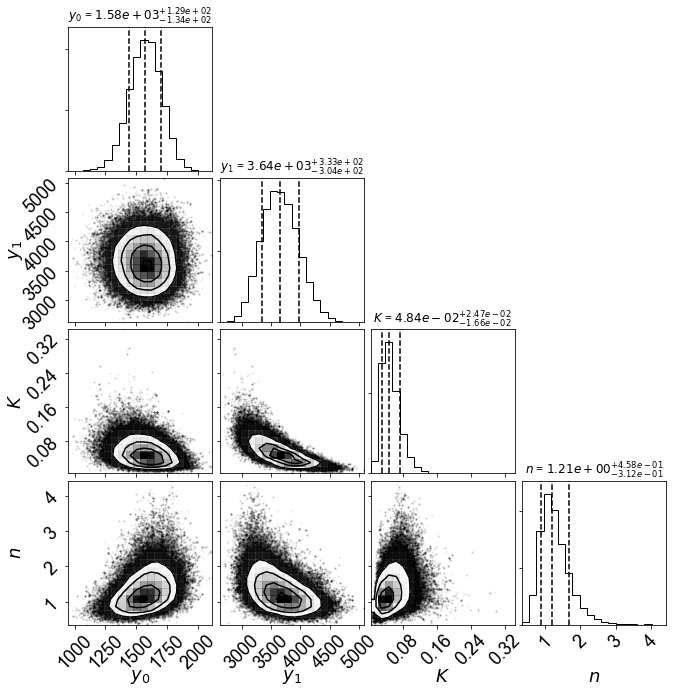

In [27]:
def lnprior(theta,y,yerr):
    y_0,y_1,K,n = theta
    if not (0<y_0 and 0<y_1 and 0<K and 0<n): 
        return -np.inf # Hard-cutoff for positive value constraint

    log_Pr1 = normalprior(y_0,y[0],yerr[0]) # Normal prior for y0
    log_Pr2 = normalprior(y_1,y[-1],yerr[-1]) # Normal prior for y1
    log_Pr3 = normalprior(K,5e-2,5e-1) # Wide normal prior for K
    log_Pr4 = normalprior(n,1,1) # Wide normal prior for n
    
    return log_Pr1 + log_Pr2 + log_Pr3 + log_Pr4


# Read GCN data
df = pd.read_csv(DIR_DATA+'2site_coop_GCN.csv',delimiter=',')
ydatnames = ['BCB+ADD cooperative', 'BCB+ADD non-cooperative', 'BCB-GCN', 'ADD-GCN']
yerrnames = ['BCB+ADD cooperative std', 'BCB+ADD non-cooperative std', 'BCB-GCN std', 'ADD-GCN std']
titration = df['ZF ratio']

xd = titration
xs = titration/2

y1 = df[ydatnames[0]].values # Cooperative
yerr1 = df[yerrnames[0]].values

y2 = df[ydatnames[1]].values # Non-cooperative
yerr2 = df[yerrnames[1]].values

y3 = df[ydatnames[2]].values # BCB-PDZ
yerr3 = df[yerrnames[2]].values

y4 = df[ydatnames[3]].values # ADD-L
yerr4 = df[yerrnames[3]].values

# Set up MCMC
np.random.seed(0) # For reproducible outputs   
parameternames = ["$y_0$","$y_1$","$K$","$n$"]
nwalkers,ndim,iterations,tburn,threads = 50,4,10000,5000,8 # Set threads correctly for parallelisation
pos = [np.array([
    y3[0]*(1+1/10*np.random.randn()), # smallest
    y3[-1]*(1+1/10*np.random.randn()), # largest
    1e-2*(1+1/10*np.random.randn()),
    1*(1+1/10*np.random.randn())
]) for i in range(nwalkers)] # Initialise walkers 

# Run MCMC
samples_noburn = MCMC(xs,y3,yerr3,'GCN_Hill_BCB',parameternames,nwalkers,ndim,
                      iterations,pos,tburn,threads,DIR_OUT,DIR_PLOTS)

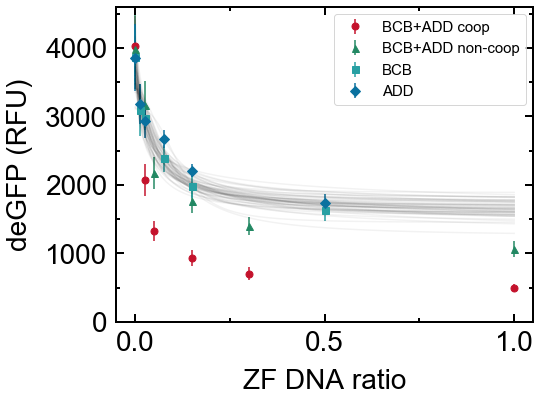

In [28]:
numberofmodeltraces=50
plottracesHill(y1,yerr1,y2,yerr2,y3,yerr3,y4,yerr4,titration,'GCN_Hill_ensemble_BCB',
               Hill,DIR_PLOTS,
               numberofmodeltraces=50,samples=samples_noburn,quant=None)

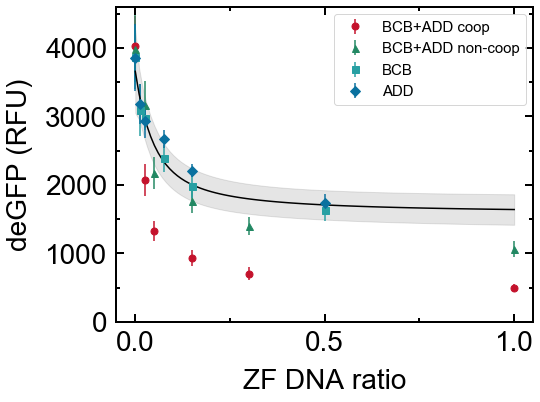

In [29]:
# Construct intervals and plot max likelihood and shaded intervals
np.random.seed(0) # For reproducible outputs   
modelscale = np.linspace(0,1,100)
numberofmodeltraces = 1000

ypred1 = np.zeros((len(modelscale),numberofmodeltraces))

i=0
for y_0,y_1,K,n in samples_noburn[np.random.randint(len(samples_noburn), size=numberofmodeltraces)]:
    ypred1[:,i] = Hill(y_0,y_1,modelscale,K,n)     
    i+=1
    
# 2-sigma distributions
quant1 = [np.mean(ypred1,axis=1)-2*np.std(ypred1,axis=1),
          np.mean(ypred1,axis=1),
          np.mean(ypred1,axis=1)+2*np.std(ypred1,axis=1)]

quant = [quant1]

plottracesHill(y1,yerr1,y2,yerr2,y3,yerr3,y4,yerr4,titration,'GCN_Hill_maxlike_BCB',
               Hill,DIR_PLOTS,
               numberofmodeltraces=50,samples=samples_noburn,quant=quant)

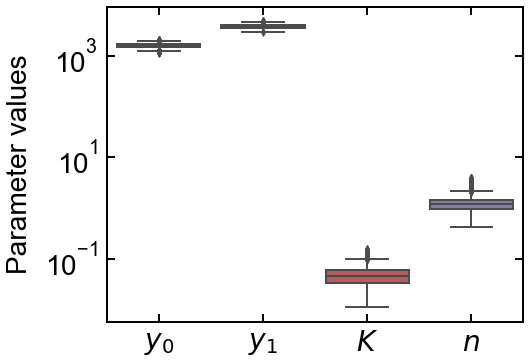

In [30]:
parameternames = ["$y_0$","$y_1$","$K$","$n$"]
nwalkers = 50
iterations = 10000
tburn = 9900
ZFname = 'GCN_Hill_BCB'
boxplots(ZFname,parameternames,nwalkers,iterations,tburn,DIR_PLOTS,DIR_OUT)

### ADD+BCB non coop

 99% (9996 of 10000) |################### | Elapsed Time: 0:05:37 ETA:  0:00:00

Quantiles:
[(0.16, 932.33641957654709), (0.5, 1034.0346735664855), (0.84, 1130.4861792705608)]
Quantiles:
[(0.16, 3549.5204684490191), (0.5, 3897.2260377090906), (0.84, 4245.9478022080457)]
Quantiles:
[(0.16, 0.034202851392334012), (0.5, 0.047416827332915634), (0.84, 0.066543066862975717)]
Quantiles:
[(0.16, 0.89398107961762374), (0.5, 1.116246757976519), (0.84, 1.4198487213795405)]


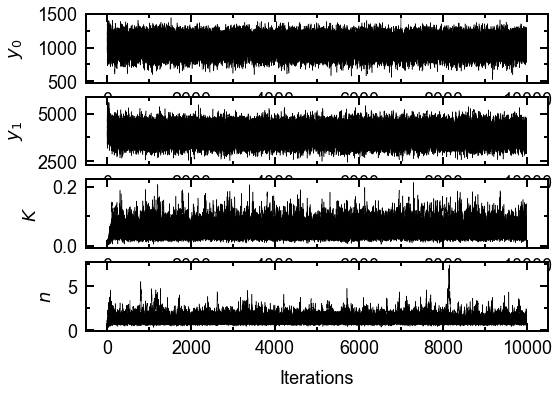

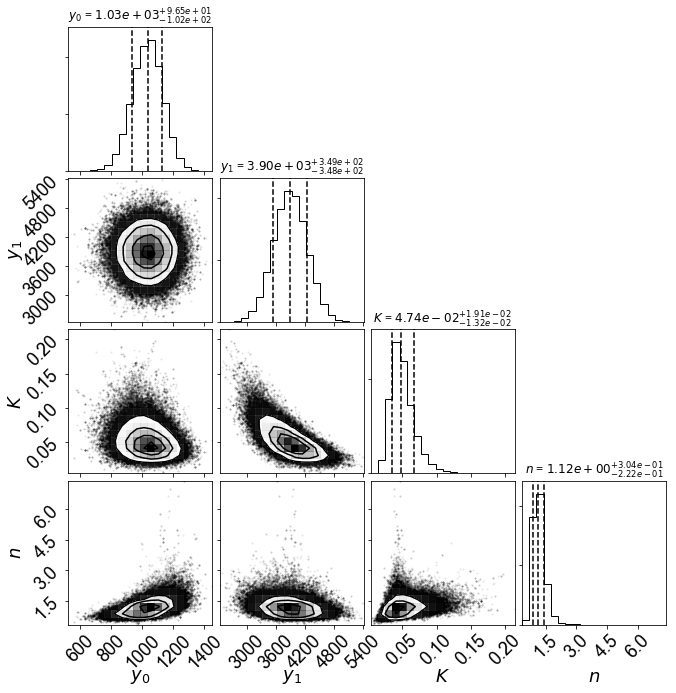

In [31]:
def lnprior(theta,y,yerr):
    y_0,y_1,K,n = theta
    if not (0<y_0 and 0<y_1 and 0<K and 0<n): 
        return -np.inf # Hard-cutoff for positive value constraint

    log_Pr1 = normalprior(y_0,y[0],yerr[0]) # Normal prior for y0
    log_Pr2 = normalprior(y_1,y[-1],yerr[-1]) # Normal prior for y1
    log_Pr3 = normalprior(K,5e-2,5e-1) # Wide normal prior for K
    log_Pr4 = normalprior(n,1,2) # Wide normal prior for n
       
    return log_Pr1 + log_Pr2 + log_Pr3 + log_Pr4

# Read GCN data
df = pd.read_csv(DIR_DATA+'2site_coop_GCN.csv',delimiter=',')
ydatnames = ['BCB+ADD cooperative', 'BCB+ADD non-cooperative', 'BCB-GCN', 'ADD-GCN']
yerrnames = ['BCB+ADD cooperative std', 'BCB+ADD non-cooperative std', 'BCB-GCN std', 'ADD-GCN std']
titration = df['ZF ratio']

xd = titration
xs = titration/2

y1 = df[ydatnames[0]].values # Cooperative
yerr1 = df[yerrnames[0]].values

y2 = df[ydatnames[1]].values # Non-cooperative
yerr2 = df[yerrnames[1]].values

y3 = df[ydatnames[2]].values # BCB-PDZ
yerr3 = df[yerrnames[2]].values

y4 = df[ydatnames[3]].values # ADD-L
yerr4 = df[yerrnames[3]].values

# Set up MCMC
np.random.seed(0) # For reproducible outputs   
parameternames = ["$y_0$","$y_1$","$K$","$n$"]
nwalkers,ndim,iterations,tburn,threads = 50,4,10000,5000,2 # Set threads correctly for parallelisation
pos = [np.array([
    y2[0]*(1+1/10*np.random.randn()), # smallest
    y2[-1]*(1+1/10*np.random.randn()), # largest
    1e-2*(1+1/10*np.random.randn()),
    1*(1+1/10*np.random.randn())
]) for i in range(nwalkers)] # Initialise walkers 

# Run MCMC
samples_noburn = MCMC(xd,y2,yerr2,'GCN_Hill_nc',parameternames,nwalkers,ndim,
                      iterations,pos,tburn,threads,DIR_OUT,DIR_PLOTS)

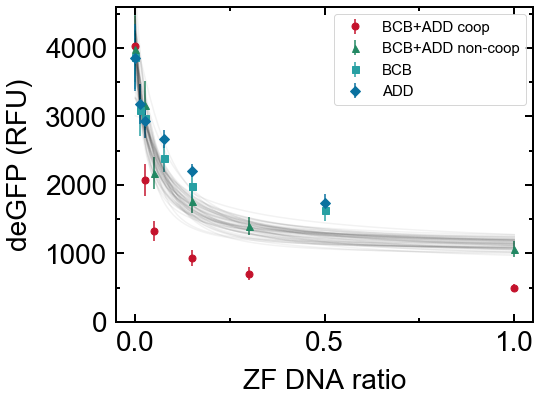

In [32]:
numberofmodeltraces = 50
plottracesHill(y1,yerr1,y2,yerr2,y3,yerr3,y4,yerr4,titration,'GCN_Hill_ensemble_nc',
               Hill,DIR_PLOTS,
               numberofmodeltraces=50,samples=samples_noburn,quant=None)

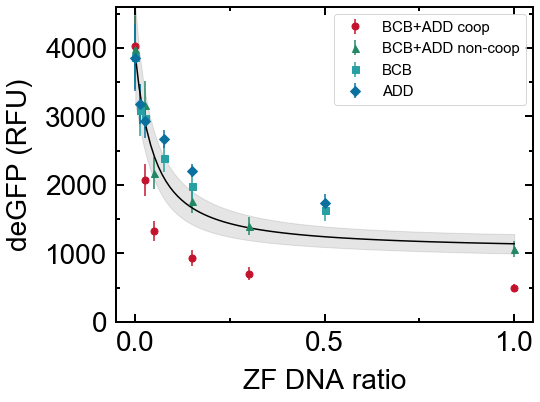

In [33]:
# Construct intervals and plot max likelihood and shaded intervals
np.random.seed(0) # For reproducible outputs   
modelscale = np.linspace(0,1,100)
numberofmodeltraces = 1000

ypred1 = np.zeros((len(modelscale),numberofmodeltraces))

i=0
for y_0,y_1,K,n in samples_noburn[np.random.randint(len(samples_noburn), size=numberofmodeltraces)]:
    ypred1[:,i] = Hill(y_0,y_1,modelscale,K,n)     
    i+=1
    
# 2-sigma distributions
quant1 = [np.mean(ypred1,axis=1)-2*np.std(ypred1,axis=1),
          np.mean(ypred1,axis=1),
          np.mean(ypred1,axis=1)+2*np.std(ypred1,axis=1)]

quant = [quant1]

plottracesHill(y1,yerr1,y2,yerr2,y3,yerr3,y4,yerr4,titration,'GCN_Hill_maxlike_nc',
               Hill,DIR_PLOTS,
               numberofmodeltraces=50,samples=samples_noburn,quant=quant)

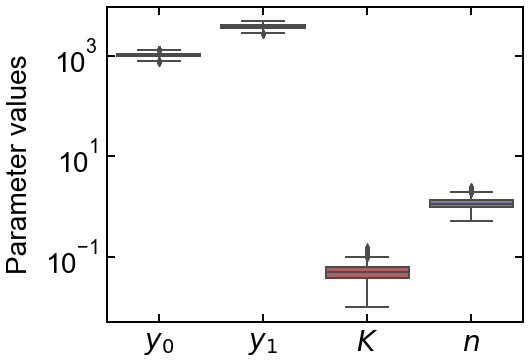

In [34]:
parameternames = ["$y_0$","$y_1$","$K$","$n$"]
nwalkers = 50
iterations = 10000
tburn = 9900
ZFname = 'GCN_Hill_nc'
boxplots(ZFname,parameternames,nwalkers,iterations,tburn,DIR_PLOTS,DIR_OUT)

### ADD+BCB coop

 99% (9997 of 10000) |################### | Elapsed Time: 0:06:04 ETA:  0:00:00

Quantiles:
[(0.16, 414.62660944113986), (0.5, 462.75086257049958), (0.84, 508.80737724053574)]
Quantiles:
[(0.16, 2892.517078755739), (0.5, 3082.8626260806304), (0.84, 3275.4848863310995)]
Quantiles:
[(0.16, 0.043887726764380783), (0.5, 0.045913484599071595), (0.84, 0.047943540790193293)]
Quantiles:
[(0.16, 1.1202641784855971), (0.5, 1.3054315743069025), (0.84, 1.541239364963827)]


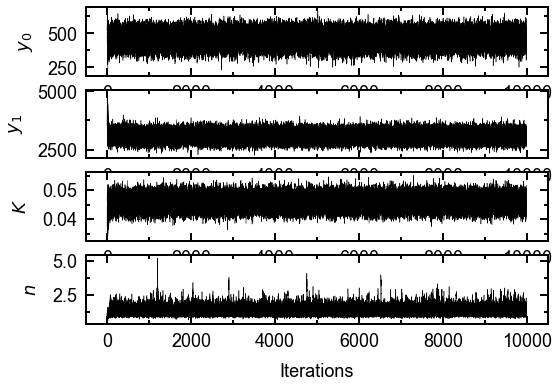

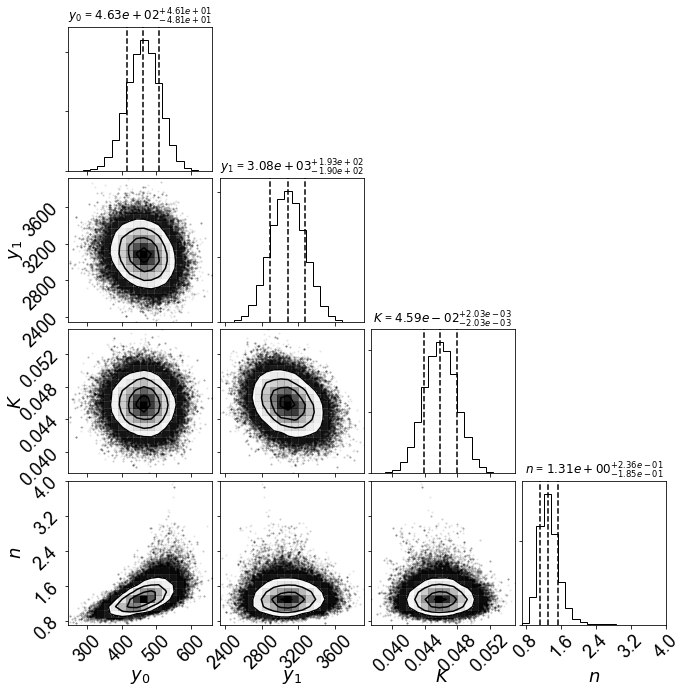

In [35]:
# Change priors

def lnprior(theta,y,yerr):
    y_0,y_1,K,n = theta
    if not (0<y_0 and 0<y_1 and 0<K and 0<n): 
        return -np.inf # Hard-cutoff for positive value constraint

    log_Pr1 = normalprior(y_0,y[0],yerr[0]) # Normal prior for y0
    log_Pr2 = normalprior(y_1,y[-1],yerr[-1]) # Normal prior for y1
    log_Pr3 = normalprior(K,0.047318085811940962,2e-3) # Strong prior for K, essentially fixed by non-coop experiment
    log_Pr4 = normalprior(n,1,2) # Wide normal prior for n

    return log_Pr1 + log_Pr2 + log_Pr3 + log_Pr4

# Read GCN data
df = pd.read_csv(DIR_DATA+'2site_coop_GCN.csv',delimiter=',')
ydatnames = ['BCB+ADD cooperative', 'BCB+ADD non-cooperative', 'BCB-GCN', 'ADD-GCN']
yerrnames = ['BCB+ADD cooperative std', 'BCB+ADD non-cooperative std', 'BCB-GCN std', 'ADD-GCN std']
titration = df['ZF ratio']

xd = titration
xs = titration/2

y1 = df[ydatnames[0]].values # Cooperative
yerr1 = df[yerrnames[0]].values

y2 = df[ydatnames[1]].values # Non-cooperative
yerr2 = df[yerrnames[1]].values

y3 = df[ydatnames[2]].values # BCB-PDZ
yerr3 = df[yerrnames[2]].values

y4 = df[ydatnames[3]].values # ADD-L
yerr4 = df[yerrnames[3]].values

# Set up MCMC
np.random.seed(0) # For reproducible outputs   
parameternames = ["$y_0$","$y_1$","$K$","$n$"]
nwalkers,ndim,iterations,tburn,threads = 50,4,10000,5000,2 # Set threads correctly for parallelisation
pos = [np.array([
    y1[0]*(1+1/10*np.random.randn()), # smallest
    y1[-1]*(1+1/10*np.random.randn()), # largest
    4e-2*(1+1/10*np.random.randn()),
    1*(1+1/10*np.random.randn())
]) for i in range(nwalkers)] # Initialise walkers 

# Run MCMC
samples_noburn = MCMC(xd,y1,yerr1,'GCN_Hill_c',parameternames,nwalkers,ndim,
                      iterations,pos,tburn,threads,DIR_OUT,DIR_PLOTS)

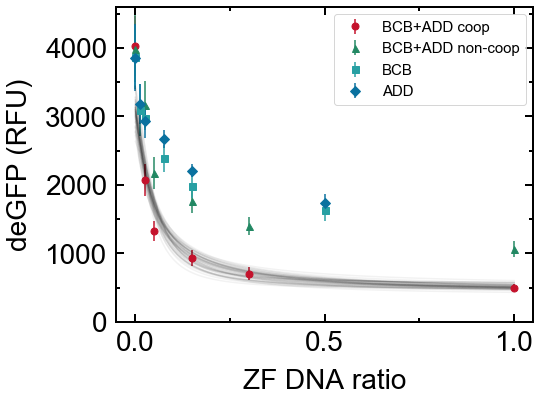

In [36]:
numberofmodeltraces=50
plottracesHill(y1,yerr1,y2,yerr2,y3,yerr3,y4,yerr4,titration,'GCN_Hill_ensemble_c',
               Hill,DIR_PLOTS,
               numberofmodeltraces=50,samples=samples_noburn,quant=None)

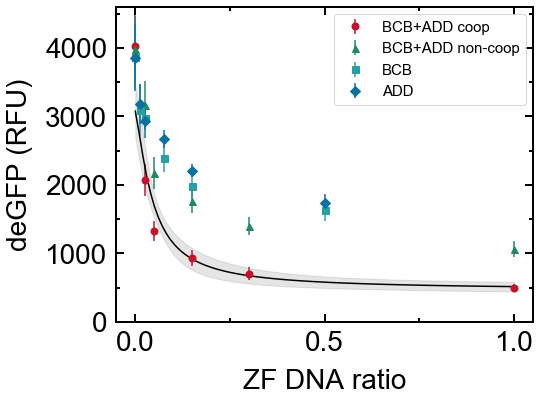

In [37]:
# Construct intervals and plot max likelihood and shaded intervals
np.random.seed(0) # For reproducible outputs   
modelscale = np.linspace(0,1,100)
numberofmodeltraces = 1000

ypred1 = np.zeros((len(modelscale),numberofmodeltraces))

i=0
for y_0,y_1,K,n in samples_noburn[np.random.randint(len(samples_noburn), size=numberofmodeltraces)]:
    ypred1[:,i] = Hill(y_0,y_1,modelscale,K,n)     
    i+=1
    
# 2-sigma distributions
quant1 = [np.mean(ypred1,axis=1)-2*np.std(ypred1,axis=1),
          np.mean(ypred1,axis=1),
          np.mean(ypred1,axis=1)+2*np.std(ypred1,axis=1)]

quant = [quant1]

plottracesHill(y1,yerr1,y2,yerr2,y3,yerr3,y4,yerr4,titration,'GCN_Hill_maxlike_c',
               Hill,DIR_PLOTS,
               numberofmodeltraces=50,samples=samples_noburn,quant=quant)

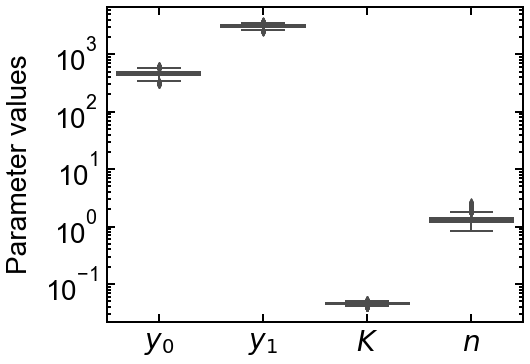

In [38]:
parameternames = ["$y_0$","$y_1$","$K$","$n$"]
nwalkers = 50
iterations = 10000
tburn = 9900
ZFname='GCN_Hill_c'
boxplots(ZFname,parameternames,nwalkers,iterations,tburn,DIR_PLOTS,DIR_OUT)

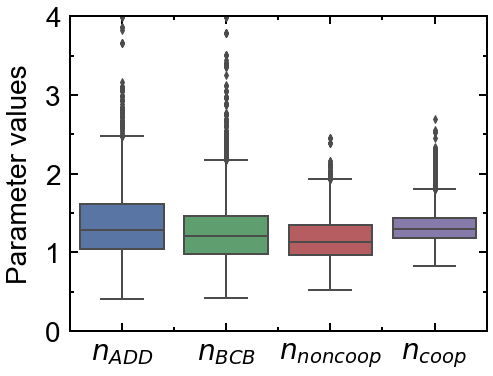

In [39]:
boxplots2(nwalkers,iterations,tburn,'GCN',DIR_PLOTS,DIR_OUT)